In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # avoid warning when using a tokenizer to calculate the coherence score during evaluation of a topic model
import sys
import json
import numpy as np
import re
import string
import pandas as pd
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="gray")

# download stopwords and tokenizers
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")

# Get the parent directory of the current notebook directory and add it to the python path to import custom modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from util.clustering_utils import *

/opt/anaconda3/envs/telegram_chat_clustering_3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewinzen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andrewinzen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewinzen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Clustering Experiment

In this notebook, we will cluster the chats using the chat representations created in `02_feature_engineering` with BERTopic.

To address the randomness inherent in topic modeling, we will run the model multiple times, analyzing the average evaluation metrics and selecting the iteration closest to these averages.

The overall process will be the same for each feature, with some adjustments to accommodate their specific characteristics:

1. **Load the Chat Representations**: Import the chat representations.

2. **Cluster Using BERTopic**: Apply BERTopic to the chat embeddings.

3. **Evaluate Performance**: Analyze the average evaluation metrics across multiple runs.

4. **Visualize Clusters**: Create visualizations to represent the clustered topics.

5. **Inspect Representative Texts**: Identify the most representative texts for each topic.

While doing so, we"ll create data and visualizations to compare the results by:

1. **Comparing Evaluation Metrics**: Collect the evaluation metrics across different models to identify the best-performing one and assess the impact of including different features on the clustering results.

2. **Comparing Topic Assignments**: Inspect how topic assignments differ from those of the base model to understand the effect different features have on clustering results, using visualizations and the Adjusted Rand Index.

3. **Qualitatively Assess the Topics**: Extract the most representative texts, keywords, and topic maps to qualitatively assess the results of each model.

## 1. Preparations


Before we start clustering the data, we have to:

1. **Load the Dataset:** In  order to inpect message later on, we"ll need to load the dataset we used to create the chat representations. 

2. **Create Chat-Text Aggregations:** Since we will use chat embeddings generated in a previous notebook rather than relying on BERTopic to create its own embeddings, we need to create custom text documents associated with each representation. These will be passed to BERTopic in order to ensure that the topics identified by BERTopic are interpretable.

#### 1. Load The Dataset

First, we"ll load the dataset.

In [2]:
dataset_path = os.path.join(os.getcwd(), "../data/preprocessed/df_preprocessed.pkl")

with open(dataset_path, "rb") as f:
    df = pickle.load(f)

df.shape

(1581498, 43)

#### 2. Create Chat-Text-Aggregations for Topic-Interpretability

To ensure the interpretability of the topics generated by BERTopic, we need to provide it with the message texts we used to create features for each chat. 

To make sure that the "chat-text-aggregations" used for this purpose are as meaningful as possible, we will perform the following operations: 

- **Basic preprocessing**, including lowercasing, stop word removal, removal of punctuation and digits, and tokenization.

- **Removing custom stopwords** specific to the Telegram domain, such as:

    - Telegram chat handles, which are frequently used to "sign" each  message in broadcast chats and could distort the analysis of the most common words.

    - Common social media call-to-action phrases, such as "share," "follow," and "comment," which are often repeated irrespective of topic.

- **Multilingual processing:** Since our corpus is multilingual, language-dependent preprocessing will be applied only to messages in the most frequent languages, as the other languages contribute only a marginal number of messages.
- **TF-IDF filtering:** We will filter out words below a certain TF-IDF threshold to ensure that only distinctive terms are included in the aggregation.

Afterwards, we will aggregate the messages and webpage previews for each chat into a single string. This string, along with the chat vector representations created earlier, will be passed to BERTopic as a basis for its topic description.

##### 1. Preprocess Data

**Define the Preprocessing Function**

In [3]:
def preprocess(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Preprocess the text data in a specified column of a DataFrame by performing several cleaning operations.
    
    Parameters:
        df (pd.DataFrame): the DataFrame containing the text to preprocess.
        text_column (str): the name of the column that contains the text to clean.

    Returns:
        pd.DataFrame: a DataFrame with additional columns for cleaned (<text_column>_cleaned) and tokenized 
        (<text_column>_preprocessed) text.
    """

    print("Preprocessing messages...")

    # get stop words 
    stop_words_en = set(stopwords.words("english"))
    stop_words_de = set(stopwords.words("german"))

    cta_stop_words_en = {"click", "tap", "press", "subscribe", "follow", "share", "like", "comment",
                        "join", "sign", "visit", "download", "register", "give", "message", "chat", "group", "channel", "bot", "reply"}
    cta_stop_words_de = {"klicken", "tippen", "drücken", "abonnieren", "folgen", "teilen", "mögen", "kommentieren",
                        "beitreten", "anmelden", "besuchen", "herunterladen", "registrieren", "geben", "message", "chat", "group", "channel", "bot", "reply"}

    stop_words_en = stop_words_en.union(cta_stop_words_en)
    stop_words_de = stop_words_de.union(cta_stop_words_de)
    print("Stop words loaded")

    # get frequent chat handles
    frequent_chat_handles = df["referenced_chat_handles"].explode().value_counts()
    frequent_chat_handles = frequent_chat_handles[frequent_chat_handles > 100].index.tolist()
    print("Frequent chat handles loaded")

    # create regex patterns
    def create_pattern(words):
        return rf"\b(?:{"|".join(map(re.escape, words))})\b"

    frequent_chat_pattern = create_pattern(frequent_chat_handles)
    stop_words_en_pattern = create_pattern(stop_words_en)
    stop_words_de_pattern = create_pattern(stop_words_de)
    print("Regex-Patterns created")
    
    # remove the most frequent chat handles  #TODO: Seems not to work
    df[f"{text_column}_cleaned"] = df[text_column].str.replace(frequent_chat_pattern, "", regex=True, flags=re.IGNORECASE).str.strip()
    print("Handles removed")

    # remove URLs
    pattern = r"(https?:\/\/[^\s/$.?#].[^\s]*[^\s.,?!)](?![\])]))|(www\.[^\s/$.?#].[^\s]*[^\s.,?!)](?![\])]))|(t\.me\/[^\s.,?!)]*)"
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.replace(pattern, "", regex=True).str.strip()
    print("URLs removed")

    # lowercase text
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.lower()
    print("Lowercase")
    
    # remove punctuation
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.replace(f"[{re.escape(string.punctuation)}]", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
    print("Punctuation removed")

    # remove the most frequent chat handles that included an @
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.replace(frequent_chat_pattern, "", regex=True, flags=re.IGNORECASE).str.strip()
    print("Handles with @ removed")

    # remove punctuation again
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.replace(f"[{re.escape(string.punctuation)}]", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
    print("Punctuation removed")

    # remove digits
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].str.replace(r"\d+", "", regex=True).str.strip()
    print("Digits removed")

    # remove english stop words
    df.loc[df["message_text_lang"] == "English", f"{text_column}_cleaned"] = \
        df.loc[df["message_text_lang"] == "English", f"{text_column}_cleaned"].str.replace(stop_words_en_pattern, "", regex=True, flags=re.IGNORECASE).str.strip()
    print("English stop words removed")

    # remove german stop words
    df.loc[df["message_text_lang"] == "German", f"{text_column}_cleaned"] = \
        df.loc[df["message_text_lang"] == "German", f"{text_column}_cleaned"].str.replace(stop_words_de_pattern, "", regex=True, flags=re.IGNORECASE).str.strip()
    print("German stop words removed")

    # fill NaN with empty string
    df[f"{text_column}_cleaned"] = df[f"{text_column}_cleaned"].fillna("")
    
    # tokenize text
    df[f"{text_column}_preprocessed"] = df[f"{text_column}_cleaned"].apply(lambda x: word_tokenize(x) if x else [])

    df[f"{text_column}_preprocessed"] = df[f"{text_column}_preprocessed"].apply(lambda x: " ".join(x))
    print("Tokenized")

    return df

**Apply Preprocessing to Message Texts**

In [4]:
# check, if the data was already preprocessed
preprocessen_msg_path = os.path.join(os.getcwd(), "../data/preprocessed/preprocessed_msgs_viz.pkl")
already_preprocessed = os.path.exists(preprocessen_msg_path)
already_preprocessed

True

In [5]:
if not already_preprocessed:

    # apply preprocessing
    df = preprocess(df, "message_text")

    # save the preprocessed data
    df["message_text_preprocessed"].to_pickle(preprocessen_msg_path)
    print("Preprocessed messages saved")

else:
    print("Loading preprocessed messages...")
    preprocessed_msg = pd.read_pickle(preprocessen_msg_path)
    df["message_text_preprocessed"] = preprocessed_msg

# display five random samples
with pd.option_context("display.max_colwidth", None):
    display(df[["message_text", "message_text_preprocessed", "referenced_chat_handles"]].sample(5))

Loading preprocessed messages...


,message_text,message_text_preprocessed,referenced_chat_handles
156084,,,NaN
1366719,Cows see grass for the first time ➠ @godlyvibez ️,cows see grass first time ➠ ️,[godlyvibez]
212222,„Ich wähle RECHTS!“,„ wähle rechts “,NaN
753161,,,NaN
1017439,"Der Magnetmotor funktioniert doch die Finanzelite will ihn nicht haben Wenn der Magnetmotor in ein Kraftfahrzeug integriert wäre, würde er einen Generator antreiben, der elektrische Energie erzeugt und diese in Batterien speist. Ansonsten würde das Fahrzeug wie ein herkömmliches Elektroauto funktionieren, das aktuell von der Automobilindustrie in Massenproduktion hergestellt wird. Diese Fahrzeuge sind emissionsfrei und leise, haben jedoch eine unbegrenzte Reichweite, sodass Tanken nie erforderlich wäre. Ebenfalls wäre dieses Prinzip genauso in unseren Haushalten nutzbar. Jetzt beitreten: XFilesUnveiled",magnetmotor funktioniert finanzelite magnetmotor kraftfahrzeug integriert wäre generator antreiben elektrische energie erzeugt batterien speist ansonsten fahrzeug herkömmliches elektroauto funktionieren aktuell automobilindustrie massenproduktion hergestellt fahrzeuge emissionsfrei leise jedoch unbegrenzte reichweite sodass tanken nie erforderlich wäre ebenfalls wäre prinzip genauso haushalten nutzbar,[xfilesunveiled]


**Apply Preprocessing to Webpage Previews**

In [6]:
# check, if the data was already preprocessed
preprocessen_web_path = os.path.join(os.getcwd(), "../data/preprocessed/preprocessed_web_viz.pkl")
already_preprocessed = os.path.exists(preprocessen_web_path)
already_preprocessed

True

In [7]:
if not already_preprocessed:
    # apply preprocessing
    df = preprocess(df, "webpage_description")

**Remove Emojis**

In [8]:
# create a list of emoji-unicodes using data from "https://unicode.org/Public/emoji/15.1/"
if not already_preprocessed:

    # list the paths to the unicode-files
    path_1 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-sequences.txt")
    path_2 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-test.txt")
    path_3 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-zwj-sequences.txt")
    file_paths = [path_1, path_2, path_3]

    # load all emojis from the unicode-files
    emoji_sequences = load_emoji_list(file_paths)

    # create a regex pattern from the emoji sequence
    emoji_pattern = "|".join(re.escape(emoji) for emoji in emoji_sequences)
    print("Emoji pattern created")

    def demojize_chunk(chunk, emoji_pattern):
        # remove emojis
        chunk["webpage_description_preprocessed"] = chunk["webpage_description_preprocessed"].str.replace(emoji_pattern, " ", regex=True)
        return chunk

    n_jobs = 3  # use three cores (seems to be fastest?)

    # remove emojis in parallel for each chunk
    chunks = np.array_split(df, n_jobs)
    df_chunks = Parallel(n_jobs=n_jobs)(delayed(demojize_chunk)(chunk, emoji_pattern) for chunk in chunks)
    df = pd.concat(df_chunks, ignore_index=True)

    # save the preprocessed data
    df["webpage_description_preprocessed"].to_pickle(preprocessen_web_path)
    print("Preprocessed messages saved")    

# simply load the preprocessed data, if it was already preprocessed
else:
    print("Loading preprocessed webpage previews...")
    preprocessed_web_previews = pd.read_pickle(preprocessen_web_path)
    df["webpage_description_preprocessed"] = preprocessed_web_previews

Loading preprocessed webpage previews...


##### 2. Apply TF-IDF-Filtering

**Apply TF-IDF-Filtering to Message Texts**

In [9]:
tfidf_path = os.path.join(os.getcwd(), "../data/preprocessed/tfidf_msgs_viz.pkl")
already_tfidf = os.path.exists(tfidf_path)
already_tfidf

True

In [10]:
if not already_tfidf:
    # isolate English and German texts and prepare them for TF-IDF vectorization
    english_texts = df[df["message_text_lang"] == "English"]["message_text_preprocessed"]
    german_texts = df[df["message_text_lang"] == "German"]["message_text_preprocessed"]

    # create and fit TF-IDF vectorizers based on the isolated texts
    tfidf_vectorizer_en = TfidfVectorizer(ngram_range=(1,1))
    tfidf_vectorizer_de = TfidfVectorizer(ngram_range=(1,1)) 
    tfidf_vectorizer_en.fit(english_texts)
    tfidf_vectorizer_de.fit(german_texts)

    feature_names_en = tfidf_vectorizer_en.get_feature_names_out()
    feature_names_de = tfidf_vectorizer_de.get_feature_names_out()

    def apply_tf_idf_threshold(row, tfidf_vectorizer_en, tfidf_vectorizer_de, threshold):

        if row["message_text_lang"] == "English":
            tfidf_vectorizer = tfidf_vectorizer_en
            feature_names = feature_names_en
        elif row["message_text_lang"] == "German":
            tfidf_vectorizer = tfidf_vectorizer_de
            feature_names = feature_names_de
        else:
            return row["message_text_preprocessed"]

        tfidf_matrix = tfidf_vectorizer.transform([row["message_text_preprocessed"]])
        tfidf_values = tfidf_matrix.toarray().flatten()
        
        distinctive_words = [feature_names[i] for i in np.where(tfidf_values > threshold)[0]]

        return " ".join(distinctive_words)

    # apply the threshold to the TF-IDF values
    df["message_text_tfidf"] = df.apply(lambda x: apply_tf_idf_threshold(x, tfidf_vectorizer_en, tfidf_vectorizer_de, 0.15), axis=1)

    # save the preprocessed messages
    df["message_text_tfidf"].to_pickle(tfidf_path)

else:
    print("Loading tf-idf filtered messages...")
    tfidf_filtered_msg = pd.read_pickle(tfidf_path)
    df["message_text_tfidf"] = tfidf_filtered_msg

Loading tf-idf filtered messages...


**Apply TF-IDF-Filtering to Webpage Previews**

In [11]:
tfidf_path = os.path.join(os.getcwd(), "../data/preprocessed/tfidf_web_viz.pkl")
already_tfidf = os.path.exists(tfidf_path)
already_tfidf

True

In [12]:
if not already_tfidf:
    # isolate English and German texts and prepare them for TF-IDF vectorization
    english_texts = df[df["webpage_description_lang"] == "English"]["webpage_description_preprocessed"]
    german_texts = df[df["webpage_description_lang"] == "German"]["webpage_description_preprocessed"]

    # create and fit TF-IDF vectorizers based on the isolated texts
    tfidf_vectorizer_en = TfidfVectorizer(ngram_range=(1,1))
    tfidf_vectorizer_de = TfidfVectorizer(ngram_range=(1,1)) 
    tfidf_vectorizer_en.fit(english_texts)
    tfidf_vectorizer_de.fit(german_texts)

    feature_names_en = tfidf_vectorizer_en.get_feature_names_out()
    feature_names_de = tfidf_vectorizer_de.get_feature_names_out()

    def apply_tf_idf_threshold_web(row, tfidf_vectorizer_en, tfidf_vectorizer_de, threshold):

        if row["webpage_description_lang"] == "English":
            tfidf_vectorizer = tfidf_vectorizer_en
            feature_names = feature_names_en
        elif row["webpage_description_lang"] == "German":
            tfidf_vectorizer = tfidf_vectorizer_de
            feature_names = feature_names_de
        else:
            return row["webpage_description_preprocessed"]

        tfidf_matrix = tfidf_vectorizer.transform([row["webpage_description_preprocessed"]])
        tfidf_values = tfidf_matrix.toarray().flatten()
        
        distinctive_words = [feature_names[i] for i in np.where(tfidf_values > threshold)[0]]

        return " ".join(distinctive_words)

    # apply the threshold to the TF-IDF values
    df["webpage_description_tfidf"] = df.apply(lambda x: apply_tf_idf_threshold_web(x, tfidf_vectorizer_en, tfidf_vectorizer_de, 0.15), axis=1)

    # save the preprocessed messages
    df["webpage_description_tfidf"].to_pickle(tfidf_path)

else:
    print("Loading tf-idf-filtered messages...")
    tfidf_filtered_msg = pd.read_pickle(tfidf_path)
    df["webpage_description_tfidf"] = tfidf_filtered_msg

Loading tf-idf-filtered messages...


##### 3. Create Chat-Text-Aggregations for each Chat

Now, we create message aggregations that will be handed to BERTopic in order to make topic interpretable.

In [13]:
grouped = df.groupby("telegram_chat_id")
chat_texts = grouped["message_text_tfidf"].agg(lambda x: " ".join(x))
chat_texts = chat_texts.astype(str)
chat_texts

telegram_chat_id
1088678000    brush forget teeth egypt views beautiful view ...
1100528049    absage absagen gesundheitszustand konzert lena...
1106758760    earth transition unprecedented body crystal sh...
1114384948    erdbeben ergebnisse ersten erstmals frankreich...
1127888562    angreifer berührter boden danach erinnern gesi...
                                    ...                        
2109703003       bauen bauern essen fall her joe landwirten ...
2112932878    denise dm fein grüße habt harmonics impulsen m...
2117576592    grocery healthylife know secret shopping us da...
2118786195    bezaubernd kind kinder liebe mehr tun warum fr...
2138374794    besiegelt dreistelliger finanzpaket lebende mi...
Name: message_text_tfidf, Length: 351, dtype: object

##### 4. Create Webpage-Preview-Aggregations for each Chat

We repeat the same process for webpage preview texts.

In [14]:
grouped = df.groupby("telegram_chat_id")
chat_webpage_previews = grouped["webpage_description_tfidf"].agg(lambda x: " ".join(x))
chat_webpage_previews = chat_webpage_previews.astype(str)
chat_webpage_previews

telegram_chat_id
1088678000                                                  ...
1100528049    absage absagen allgäu auftritt konzert landrut...
1106758760                                                  ...
1114384948    erdbeben ergebnisse ersten erstmals frankreich...
1127888562                          basierten drunkpunkjunk ...
                                    ...                        
2109703003                                                  ...
2112932878                                            birken...
2117576592                                                  ...
2118786195                    chemie gesundes helfen hilft l...
2138374794    bericht bundesregierung dreistelliger finanzpa...
Name: webpage_description_tfidf, Length: 351, dtype: object

## 2. Basic Chat Embeddings

To start of, we"ll cluster the chats in our dataset using an aggregation of the embeddings of messages sent inside of them. 

This model will act as a baseline. 

#### 1. Load Chat Representations

First, we load the chat representations we created in the notebook `02_feature_engineering`.

In [15]:
base_path = os.path.join(os.getcwd(), "../features/0_base_chat_vectors.npy")
base_chat_vectors = np.load(base_path, allow_pickle=True)
print(f"Number of chat vectors: {base_chat_vectors.shape[0]}")
print(f"Vector Dimension: {base_chat_vectors.iloc[0].shape}")
base_chat_vectors

Number of chat vectors: 351
Vector Dimension: (384,)


telegram_chat_id
1088678000    [0.1263766073179652, 0.05394563817068299, 0.05...
1100528049    [-0.023233175288204094, 0.09989558492405338, -...
1106758760    [0.042088846805800655, 0.03061037621607788, 0....
1114384948    [0.015081686089090711, 0.18715866830595776, -0...
1127888562    [-0.06275966569274828, 0.07046570646658255, -0...
                                    ...                        
2109703003    [-0.022255021208905136, 0.07689504962285018, -...
2112932878    [0.08306009970249655, 0.03701082738495624, 0.0...
2117576592    [-0.06356400540833393, -0.019289514661497673, ...
2118786195    [-0.008770940284807625, 0.05829667346273892, -...
2138374794    [-0.017311744546580264, 0.12816830782920283, -...
Name: message_text_embeddings, Length: 351, dtype: object

#### 2. Cluster the embeddings

Now we can use BERTopic to cluster the embeddings. 

In addition to clustering, BERTopic will also automatically create summaries for each topic using a representational model. The method chosen here, KeyBERT-inspired, extracts keywords from all documents assigned to a topic using BERT embeddings.

We will also create visualisations of clusters.

In [16]:
# load the model we used to create the embeddings, in order to use it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

# check, if the base embeddings were already processed
feature_name = "base"
base_done = is_processed(feature_name)

# load the results, if the base embeddings were already processed
if base_done:
    print("Base embeddings already processed. Loading results...")
    base_evaluation_metrics, base_topic_model, representative_messages, representative_webpages = load_data(feature_name)
    
# run the experiment, if the base embeddings were not already processed
else:
    print("Running experiment for base embeddings...")
    base_evaluation_metrics, base_topics, base_probabilities, base_topic_model = run_experiment(
        chat_embeddings=base_chat_vectors, 
        chat_texts=chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/base_embeddings/topic_models/"),
        feature_name=feature_name,
        used_embedding_model=transformer_model
    )

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Base embeddings already processed. Loading results...


#### 3. Inspect the average evaluation metrics

In [17]:
for key, value in base_evaluation_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.4595140194572657
Silhouette Scores: 0.14638398678420722
Davies Bouldin Scores: 2.1003440353729665
Topic Counts: 3.76
Noise Counts: 11.0


#### 4. Visualise And Export The Results Of The Most Average Topic Model

Now we visualise the results. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [18]:
path = os.path.join(os.getcwd(), "../results/base_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(base_topic_model, base_chat_vectors, chat_texts, path, display_plots=False)

2024-10-28 19:06:02,142 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:06:02,351 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 2/2 [00:27<00:00, 13.54s/it]


2024-10-28 19:06:40,298 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 5. Inspect the most representative messages

**1. Create Topic Vectors**

We average the embeddings of all chats assigned to a topic model to find a topics center. This vector will be used as a topic representation.

In [19]:
if not base_done:
    topic_vectors = create_topic_vectors(base_topic_model, base_chat_vectors)
    topic_vectors

**2. For each topic, extract the top n messages closest to the topic vector they were assigned to**

First, we add the message-text-embeddings created in `02_feature_engineering` back to the messages in the DataFrame. 
We will then use them to compare the messages to the topic vectors created earlier to find the most representative messages for each topic.

In [20]:
if not base_done:
    # load the message embeddings
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is an message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df["message_vector"] = message_embeddings_series
    df[["message_text", "message_vector"]].head()

In [21]:
if not base_done:
    representative_messages = get_representative_texts(df = df,
                                                    topic_model = base_topic_model,
                                                    topic_vectors = topic_vectors,
                                                    chat_vectors = base_chat_vectors,
                                                    n = 10,
                                                    feature_name = "base",
                                                    text_column = "message_text",
                                                    text_embeddings_column = "message_vector",
                                                    text_preprocessed_column = "message_text_preprocessed")

    # save representative messages
    representative_messages_path = os.path.join(os.getcwd(), "../results/base_embeddings/representative_messages.json")
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Hier deutschsprachig:
2. #ploetzlichundunerwartet
3. das hält man ja nicht im Kopf aus. #KämpftumEuerLand
4. Unerträgliche Aussage ️ ️ @NetzwerkkritischerExperten .
5. #Plötzlichundunerwartet Aus der Rubrik: #KarmaIsABitch
6. #Schweiz: Heute über #Genf.
7. Staatsnahe #Medien in der #Schweiz schweigen: #RKIProtokolle des #RKI entschwärzt: Das sollten Sie nicht wissen
8. Bundesfinanzminister Lindner solle doch bitte ausreden können Berlin, 15.1.24
9. Wie viele wären wirklich geimpft? Mad in Germany unterstützen
10. Impftote nun plötzlich Hitzetote WICHTIG: Neue Gesetze vom 25. August 2023 gefährden JEDE Aufklärungsarbeit! Darum TEILEN – VERBREITEN – STREUEN – jetzt ist es noch möglich! Video in voller Länge: ABONNIEREN


Topic 1:
1. #Klassiker
2. Neidische Kollegen oder Freunde! So gehst du selbstbewusst damit um! 5.1K 22.09.2021 SELFCHANGER
3. einer von meinem STAMM Herzensgrüße
4. #Farbenreich
5. >> Kopf hoch! Sonst wirst du nicht sehen können, wer dir zulächelt.<< Gebt dem

## 3. Filtered Chat Embeddings

#### 1. Load The Filtered Chat Embeddings

First, we load the chat representations we created in the notebook `02_feature_engineering`

In [22]:
filtered_path = os.path.join(os.getcwd(), "../features/1_filtered_chat_vectors.npy")
filtered_chat_vectors = np.load(filtered_path, allow_pickle=True)
print(f"Number of chat vectors: {filtered_chat_vectors.shape[0]}")
print(f"Vector Dimension: {filtered_chat_vectors.iloc[0].shape}")
filtered_chat_vectors

Number of chat vectors: 350
Vector Dimension: (384,)


telegram_chat_id
1088678000    [0.12331648135193396, 0.05168804451483456, 0.0...
1100528049    [-0.024274383824285855, 0.10465835146835066, -...
1106758760    [0.059080261976756546, 0.04199281848231483, 0....
1114384948    [0.015070079501382973, 0.18771674297534244, -0...
1127888562    [-0.06972874564610768, 0.0715973633862073, -0....
                                    ...                        
2109703003    [-0.03259240649740155, 0.10988674725440398, -0...
2112932878    [0.08216053367249625, 0.03731218883044414, 0.0...
2117576592    [-0.06608138750732073, -0.021557911229187203, ...
2118786195    [-0.012232864988404708, 0.08756214008712557, -...
2138374794    [-0.013785719824888909, 0.14961547387444624, -...
Name: message_text_embeddings, Length: 350, dtype: object

#### 2. Create Filtered Chat-Message-Text-Aggregations

Now we filter the dataset to remove all Forwarded/Original-Message-Pairs using the indices we saved in  `02_feature_engineering`.

In [23]:
indices_path = os.path.join(os.getcwd(), "../features/1_implicit_ref_filtered_indices.npy")
filtered_rows_indices = np.load(indices_path)
df_references_filtered = df.loc[filtered_rows_indices]
df_references_filtered.shape

(1094123, 47)

As we removed some messages from our dataset, we need to create updated chat-text-aggregations that reflect these changes. 

In [24]:
grouped = df_references_filtered.groupby("telegram_chat_id")
filtered_chat_texts = grouped["message_text_tfidf"].agg(lambda x: " ".join(x))
filtered_chat_texts = filtered_chat_texts.astype(str)
filtered_chat_texts

telegram_chat_id
1088678000    happy mom months seconds seconds of relaxation...
1100528049             antisystem ballweg bond bösewicht ein...
1106758760     arcturian energies fields get help know knowi...
1114384948       behörden beobachtung exklusiv griff indymed...
1127888562    firma geworden got kaufen länge real shit ther...
                                    ...                        
2109703003                                             gez f...
2112932878                                                  ...
2117576592     blurred lenses morning myopia ophthalmologist...
2118786195                              bedarf gibt hinhören...
2138374794    deutschland dänemark dänen hersh pipeline scho...
Name: message_text_tfidf, Length: 350, dtype: object

#### 3. Cluster The Embeddings

Now we can use BERTopic to cluster the embeddings. Again, we will run the model multiple times and inspect the average results of the topic models.

In [25]:
# load the model we used for the embeddings, in order to reuse it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

# check, if the filtered embeddings were already processed
feature_name = "filtered"
filtered_done = is_processed(feature_name)

# load the results, if the filtered embeddings were already processed
if filtered_done:
    print("Filtered embeddings already processed. Loading results...")
    filtered_evaluation_metrics, filtered_topic_model, representative_messages, representative_webpages = load_data(feature_name)

# run the experiment, if the filtered embeddings were not already processed
else:
    print("Running experiment for filtered embeddings...")
    filtered_evaluation_metrics, filtered_topics, filtered_probabilities, filtered_topic_model = run_experiment(
        chat_embeddings=filtered_chat_vectors, 
        chat_texts=filtered_chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/filtered_embeddings/topic_models/"),
        feature_name="filtered",
        used_embedding_model=transformer_model
)

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Filtered embeddings already processed. Loading results...


#### 3. Inspect the average evaluation metrics

In [26]:
for key, value in filtered_evaluation_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.4408995779447028
Silhouette Scores: 0.13992291057549328
Davies Bouldin Scores: 2.0596486664069658
Topic Counts: 6.54
Noise Counts: 54.42


#### 4. Visualise The Clustering And Export The Visualisations

Again, we will visualise the results. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [27]:
path = os.path.join(os.getcwd(), "../results/filtered_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(filtered_topic_model, filtered_chat_vectors, filtered_chat_texts, path, display_plots=False)

2024-10-28 19:07:02,184 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:07:02,372 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 4/4 [00:42<00:00, 10.52s/it]


2024-10-28 19:07:52,691 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 5. Inspect the most representative messages

Again, we"ll inspect the most representative messages for each topic by comparing them to topic vectors derived from the topic assignments returned by the topic model.

**1. Create Topic Vectors**

We average the embeddings of all chats assigned to a topic model to find a topics center. This vector will be used as a topic representation.

In [28]:
if not filtered_done:
    topic_vectors = create_topic_vectors(filtered_topic_model, filtered_chat_vectors)
    topic_vectors

**2. Extract Top Messages**

Again, we add the embeddings created in `02_feature_engineering` back to the messages in the DataFrame and use them to find the most representative messages for each topic.

In [29]:
if not filtered_done:
    # filter the df to only include the messages that were used in the filtered chat vectors. We can use the indices saved in the feature engineering notebook
    filtered_rows_indices = np.load(indices_path)
    df_filtered = df.loc[filtered_rows_indices]

    # load the message embeddings
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is a message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df_filtered["message_vector"] = message_embeddings_series
    df_filtered[["message_text", "message_vector"]].head()

In [30]:
if not filtered_done:
    representative_messages = get_representative_texts(df = df_filtered,
                                                    topic_model = filtered_topic_model,
                                                    topic_vectors = topic_vectors,
                                                    chat_vectors = filtered_chat_vectors,
                                                    n = 10,
                                                    feature_name = "filtered",
                                                    text_column = "message_text",
                                                    text_embeddings_column = "message_vector",
                                                    text_preprocessed_column = "message_text_preprocessed")

    # save representative messages
    representative_messages_path = os.path.join(os.getcwd(), "../results/filtered_embeddings/representative_messages.json")
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Hier deutschsprachig:
2. das hält man ja nicht im Kopf aus. #KämpftumEuerLand
3. #ploetzlichundunerwartet
4. Unerträgliche Aussage ️ ️ @NetzwerkkritischerExperten .
5. #Schweiz: Heute über #Genf.
6. Der Klügere gibt nach? Bist du dir sicher? Corona Maßnahmen, der ewige Angst. Mad in Germany unterstützen
7. Staatsnahe #Medien in der #Schweiz schweigen: #RKIProtokolle des #RKI entschwärzt: Das sollten Sie nicht wissen
8. Endlich wird dieser übergriffigen WHO Saubande der Riegel vorgeschoben
9. Impftote nun plötzlich Hitzetote WICHTIG: Neue Gesetze vom 25. August 2023 gefährden JEDE Aufklärungsarbeit! Darum TEILEN – VERBREITEN – STREUEN – jetzt ist es noch möglich! Video in voller Länge: ABONNIEREN
10. AUFDECKUNG DER MILITÄRISCHEN KORRUPTION Es war alles geplant! TREASON VERBRECHEN GEGEN DIE MENSCHLICHKEIT DE Untertitel


Topic 1:
1. Seelenfrieden...
2. Seelenmenschen Gute Laune Mehr Hier
3. Genial den will ich auf für Zeiten der Not
4. Für dich Seelenschönes aus der Natur Meh

## 4. Webpage Preview Embeddings

#### 1. Load Chat Representations

First, we load the chat representations we created based on webpage previews in the notebook `02_feature_engineering`

In [31]:
webpreview_path = os.path.join(os.getcwd(), "../features/3_webpreview_chat_vectors.npy")
webpreview_chat_vectors = np.load(webpreview_path, allow_pickle=True)
print(f"Number of chat vectors: {webpreview_chat_vectors.shape[0]}")
print(f"Vector Dimension: {webpreview_chat_vectors.iloc[0].shape}")
webpreview_chat_vectors

Number of chat vectors: 351
Vector Dimension: (384,)


telegram_chat_id
1088678000    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1100528049    [-0.014660350027485287, 0.07162302777178518, -...
1106758760    [0.0005550567112212886, -0.0011561474484546967...
1114384948    [0.013210440636675234, 0.17518335552118247, -0...
1127888562    [6.402835867108679e-05, -0.00052159000987176, ...
                                    ...                        
2109703003    [-0.010031821220483749, 0.02714176292807185, -...
2112932878    [-0.0006807130166744612, 0.0002089151037460757...
2117576592    [0.0003016469553387913, -0.0001872513456978041...
2118786195    [-0.0025628763832924737, 0.0035034336836901087...
2138374794    [-0.004784296480358111, 0.018594469006142044, ...
Name: webpage_description_embeddings, Length: 351, dtype: object

#### 2. Cluster The Embeddings

Now we can use BERTopic to cluster the embeddings. 

Again, we"ll run the experiment multiple times in order to inspect average results and models. 

In [32]:
# load the model we used for the embeddings, in order to use it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

# check, if the webpreview embeddings were already processed
feature_name = "webpreview"
webpreview_done = is_processed(feature_name, True)

# load the results, if the webpreview embeddings were already processed
if webpreview_done:
    print("Webpreview embeddings already processed. Loading results...")
    webpreview_evaluation_metrics, webpreview_topic_model, representative_messages, representative_webpreviews = load_data(feature_name, True)
    
# run the experiment, if the webpreview embeddings were not already processed
else:
    print("Running experiment for webpreview embeddings...")
    webpreview_evaluation_metrics, webpreview_topics, webpreview_probabilities, webpreview_topic_model = run_experiment(
        chat_embeddings=webpreview_chat_vectors, 
        chat_texts=chat_webpage_previews, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/webpreview_embeddings/topic_models/"),
        feature_name="webpreview",
        used_embedding_model=transformer_model
    )

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Representative Web Previews exist: True
Webpreview embeddings already processed. Loading results...


#### 3. Inspect The Average Evaluation Metrics

In [33]:
for key, value in webpreview_evaluation_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.5374835507468834
Silhouette Scores: -0.2134207493159828
Davies Bouldin Scores: 3.2316045463213117
Topic Counts: 6.44
Noise Counts: 57.7


#### 4. Visualise The Clustering and Export The Visualisations

As we did before, we will visualise the results. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [34]:
path = os.path.join(os.getcwd(), "../results/webpreview_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(webpreview_topic_model, webpreview_chat_vectors, chat_webpage_previews, path, display_plots=False)

2024-10-28 19:08:02,674 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:08:02,894 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 4/4 [00:32<00:00,  8.01s/it]


2024-10-28 19:08:38,100 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 5. Inspect The Most Representative Messages

**1. Create Topic Vectors**

In [35]:
if not webpreview_done:
    topic_vectors = create_topic_vectors(webpreview_topic_model, webpreview_chat_vectors)
    display(topic_vectors)

**2. For each topic, extract the top messages closest to the topic vector they were assigned to**

Again, we add the embeddings created in `02_feature_engineering` back to the messages in the DataFrame and use them to compare them to the topic vectors created earlier to find the most representative messages for each topic.

In [36]:
# load the message embeddings
if not webpreview_done:
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is an message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df["message_vector"] = message_embeddings_series
    display(df[["message_text", "message_vector"]].head()) #TODO: Add display

In [37]:
# compare the message embeddings with the topic vectors
if not webpreview_done:
    representative_messages = get_representative_texts(df,
                                                    webpreview_topic_model,
                                                    topic_vectors,
                                                    webpreview_chat_vectors,
                                                    10,
                                                    "webpreview",
                                                    "message_text",
                                                    "message_vector",
                                                    "message_text_preprocessed")

    # save representative messages
    representative_messages_path = os.path.join(os.getcwd(), "../results/webpreview_embeddings/representative_messages.json")
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Bewußt aktuell 273 Themen; Vorurteile werden neu gemischt, Sollen wir uns vom Haß anstecken lassen oder von der Liebe? deutsche Soldaten von Hisbollah angegriffen, Massive Proteste gegen Netanjahu in Israel, hat Israel weissen Phosphor in Gaza eingesetzt? Reiner Füllmich in Frankfurt verhaftet, Epstein-Opfer nach Aussage gegen Prinz Andrew und Ghislaine Maxwell tot aufgefunden, Nancy Faeser ließ Hunderte Abgeordnete ausforschen, Bundesregierung holt Scharia-Richter nach Deutschland, Neue Studie deckt Ursachen für Herzschäden bei allen Geimpften durch mRNA-Impfungen auf, uvm.
2. Es ist der Vernichtungs-KRIEG gegen UNS ALLE Nur mit BEFREITEN MS-Medien + SCHULEN gewinnen wir ——————————————— Kein Wunder dass er auf der Abschuss-Liste steht. Zuviel Wahrheit verbreitet! Da findet sich dann etwas, was bei Wegspritz-System-Ärzten toleriert würde. Dr. Heinz Reinwald „Die Salzlüge“ macht ihn zum BigPharma-Gegner ... ——————————————— t.me/StuttgartGrundgesetzDemos Stuttgart Satire Wide

#### 6. Inspect The Most Representative Webpage-Previews

Now, we will inspect the most representative webpage-previews. To do so, we"ll compare the webpage-preview-embeddings to the topic-vectors created earlier and inspect the most similar ones.

In [38]:
# load the webpage embeddings
if not webpreview_done:
    webpreview_embeddings_path = os.path.join(os.getcwd(), "../features/3_webpage_embeddings.npy")

    # create a series where each element is an message-vector
    webpreview_embeddings = np.load(webpreview_embeddings_path)

    # add the message embeddings to the dataframe.
    df["webpreview_vector"] = webpreview_embeddings.tolist() 
    display(df[["webpage_title", "webpage_description", "webpreview_vector"]].head())

In [39]:
# compare the webpage embeddings with the topic vectors and get the most similar webpages
if not webpreview_done:
    representative_webpreviews = get_representative_texts(df, 
                                                        webpreview_topic_model, 
                                                        topic_vectors, 
                                                        webpreview_chat_vectors, 
                                                        10, 
                                                        "webpreview", 
                                                        "webpage_description",
                                                        "webpreview_vector",
                                                        "webpage_description_preprocessed")

    # save representative messages
    representative_webpreview_path = os.path.join(os.getcwd(), "../results/webpreview_embeddings/representative_webpreviews.json")
    representative_webpreviews = {int(topic): messages for topic, messages in representative_webpreviews.items()} # convert keys to int
    with open(representative_webpreview_path, "w") as jsonfile:
        json.dump(representative_webpreviews, jsonfile, indent=4)

# print representative webpreviews
for topic, text in representative_webpreviews.items():
    print(f"Topic {topic}:")
    for i, text in enumerate(text):
        print(f"{i+1}. {text.strip()}")
    print("\n")

Topic 0:
1. Justizkrimi um Linksextremisten-Auslieferung. Kaum gibt ein Berliner Gericht grünes Licht, werden d
2. Aus aktuellem Anlass veröffentlichen wir dieses spannende Gespräch erneut auf unserem Kanal. Im Februar 2020 sprach Markus Gärtner für @PrivatinvestorTV mit dem Journalisten Peter Orzechowski. Er hatte damals gerade sein Buch "Besatzungszone" veröffentlicht, das eine der wichtigsten politischen Fragen unserer Zeit beleuchtet: Wie frei und souverän ist Deutschland?   Mittlerweile ist es vollkommen deutlich geworden, dass unsere Bundesregierung nach den Befehlen Washingtons marschiert: Kanzler Scholz hat die Zerstörung der Nordstream-Pipelines durch Terroristen im Auftrag der USA regungslos hingenommen. Immer schwerere Waffen werden an das Selenski-Regime geliefert - seit Kurzem sogar noch mit der Erlaubnis, sie auf dem Gebiet der Russischen Föderation einzusetzen. Bereits vor über vier Jahren zeigte Peter Orzechowski die Hintergründe dieser verborgenen Besatzung Deutschland

## 5. Combined Message & Webpage-Preview Embeddings

Next, we combine the message- and web-preview-embeddings and inspect the changes in clustering results.

#### 1. Combine Message-Text- And Webpage-Preview-Vectors

First, we load the chat-vectors we created by averaging the webpage-preview- and message-vectors.

In [40]:
combine_vectors_path = os.path.join(os.getcwd(), "../features/3_msg_webpreview_chat_vectors.npy")
combined_vectors = np.load(combine_vectors_path, allow_pickle=True)

#### 2. Create Combined Chat-Text-Aggregations

Next, we combine the Text-Aggregations for Webpage-Previews and Chat-Messages in order to use them  to make the topics interpretable.

In [41]:
# create a DataFrame to combine the texts
combined_text_dataframe = pd.DataFrame({
    "chat_texts": chat_texts,
    "chat_webpage_previews": chat_webpage_previews
})

# combine the texts
combined_text_dataframe["combined_texts"] = combined_text_dataframe["chat_texts"] + " " + combined_text_dataframe["chat_webpage_previews"]

# calculate the length of the texts
combined_text_dataframe["chat_texts_len"] = combined_text_dataframe["chat_texts"].apply(lambda x: len(x.split()))
combined_text_dataframe["chat_webpage_previews_len"] = combined_text_dataframe["chat_webpage_previews"].apply(lambda x: len(x.split()))
combined_text_dataframe["combined_texts_len"] = combined_text_dataframe["combined_texts"].apply(lambda x: len(x.split()))

# check if the combined arrays are the same length as the original arrays combined
assert combined_text_dataframe["combined_texts_len"].equals(combined_text_dataframe["chat_texts_len"] + combined_text_dataframe["chat_webpage_previews_len"])

# get the combined texts
combined_texts = combined_text_dataframe["combined_texts"]
combined_texts

telegram_chat_id
1088678000    brush forget teeth egypt views beautiful view ...
1100528049    absage absagen gesundheitszustand konzert lena...
1106758760    earth transition unprecedented body crystal sh...
1114384948    erdbeben ergebnisse ersten erstmals frankreich...
1127888562    angreifer berührter boden danach erinnern gesi...
                                    ...                        
2109703003       bauen bauern essen fall her joe landwirten ...
2112932878    denise dm fein grüße habt harmonics impulsen m...
2117576592    grocery healthylife know secret shopping us da...
2118786195    bezaubernd kind kinder liebe mehr tun warum fr...
2138374794    besiegelt dreistelliger finanzpaket lebende mi...
Name: combined_texts, Length: 351, dtype: object

#### 3. Cluster The Combined Embeddings

Now, we can cluster the chats using the combined message- and webpage-preview embeddings.

In [42]:
# load the model we used for the embeddings, in order to use it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

# check, if the webpreview embeddings were already processed
feature_name = "combined_webpreview"
combined_webpreview_done = is_processed(feature_name, True)

# load the results, if the webpreview embeddings were already processed
if combined_webpreview_done:
    print("Combined webpreview embeddings already processed. Loading results...")
    combined_webpreview_evaluation_metrics, combined_webpreview_topic_model, representative_messages, representative_webpreviews = load_data(feature_name, True)
    
# run the experiment, if the webpreview embeddings were not already processed
else:
    print("Running experiment for combined webpreview embeddings...")

    combined_webpreview_evaluation_metrics, combined_webpreview_topics, combined_webpreview_probabilities, combined_webpreview_topic_model = run_experiment(
        chat_embeddings=combined_vectors, 
        chat_texts=combined_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/combined_webpreview_embeddings/topic_models/"),
        feature_name="combined_webpreview",
        used_embedding_model=transformer_model
    )

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Representative Web Previews exist: True
Combined webpreview embeddings already processed. Loading results...


#### 4. Inspect the average evaluation metrics

In [43]:
for key, value in combined_webpreview_evaluation_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.46666171581739535
Silhouette Scores: 0.1700830226556437
Davies Bouldin Scores: 1.9320807557361526
Topic Counts: 4.14
Noise Counts: 19.32


#### 5. Visualise The Clustering And Export The Visualisation

We will now visualise the results. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [44]:
path = os.path.join(os.getcwd(), "../results/combined_webpreview_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(combined_webpreview_topic_model, combined_vectors, combined_texts, path, display_plots=False)

2024-10-28 19:09:07,348 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:09:07,501 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 2/2 [00:35<00:00, 17.87s/it]


2024-10-28 19:09:57,092 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 6. Inspect the most representative messages

**1. Create Topic Vectors**

In [45]:
if not combined_webpreview_done:
    topic_vectors = create_topic_vectors(combined_webpreview_topic_model, combined_vectors)
    display(topic_vectors)

**2. For each topic, extract the top n messages closest to the topic vector they were assigned to**

Like with the features used before, we add the embeddings created in `02_feature_engineering` back to the messages in the DataFrame and use them to compare them to the topic vectors created earlier to find the most representative messages for each topic.

In [46]:
# load the message embeddings
if not combined_webpreview_done:
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is an message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df["message_vector"] = message_embeddings_series
    display(df[["message_text", "message_vector"]].head())

In [47]:
# get the messages closest to the topic centers
if not combined_webpreview_done:
    representative_messages = get_representative_texts(df = df,
                                                    topic_model = combined_webpreview_topic_model,
                                                    topic_vectors = topic_vectors,
                                                    chat_vectors = combined_vectors,
                                                    n = 10,
                                                    feature_name = "combined_webpreview",
                                                    text_column = "message_text",
                                                    text_embeddings_column = "message_vector",
                                                    text_preprocessed_column = "message_text_preprocessed")

    # save representative messages
    representative_messages_path = os.path.join(os.getcwd(), "../results/combined_webpreview_embeddings/representative_messages.json")
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Hier deutschsprachig:
2. Unerträgliche Aussage ️ ️ @NetzwerkkritischerExperten .
3. #ploetzlichundunerwartet
4. das hält man ja nicht im Kopf aus. #KämpftumEuerLand
5. #Plötzlichundunerwartet Aus der Rubrik: #KarmaIsABitch
6. #Schweiz: Heute über #Genf.
7. Wie viele wären wirklich geimpft? Mad in Germany unterstützen
8. Bundesfinanzminister Lindner solle doch bitte ausreden können Berlin, 15.1.24
9. Der Klügere gibt nach? Bist du dir sicher? Corona Maßnahmen, der ewige Angst. Mad in Germany unterstützen
10. Impftote nun plötzlich Hitzetote WICHTIG: Neue Gesetze vom 25. August 2023 gefährden JEDE Aufklärungsarbeit! Darum TEILEN – VERBREITEN – STREUEN – jetzt ist es noch möglich! Video in voller Länge: ABONNIEREN


Topic 1:
1. Neidische Kollegen oder Freunde! So gehst du selbstbewusst damit um! 5.1K 22.09.2021 SELFCHANGER
2. #Klassiker
3. #Farbenreich
4. einer von meinem STAMM Herzensgrüße
5. Für diejenigen, die am 24.12. die Rauhnächte beginnen
6. >> Kopf hoch! Sonst wirst d

#### 7. Inspect The Most Representative Webpage-Previews

Now, we will inspect the most representative webpage-previews using the same approach we have already used to find representative messages. We will reuse the topic vectors created while inspecting the most representative messages.

In [48]:
# load the webpage-preview embeddings
if not combined_webpreview_done:
    webpreview_embeddings_path = os.path.join(os.getcwd(), "../features/3_webpage_embeddings.npy")

    # create a series where each element is an message-vector
    webpreview_embeddings = np.load(webpreview_embeddings_path)

    # add the message embeddings to the dataframe.
    df["webpreview_vector"] = webpreview_embeddings.tolist() 
    df[["webpage_title", "webpage_description", "webpreview_vector"]].head()

In [49]:
# get the webpage previews closest to the topic centers
if not combined_webpreview_done:
    representative_webpreviews = get_representative_texts(df, 
                                                        combined_webpreview_topic_model, 
                                                        topic_vectors, 
                                                        combined_vectors, 
                                                        10, 
                                                        "combined_webpreview", 
                                                        "webpage_description",
                                                        "webpreview_vector",
                                                        "webpage_description_preprocessed")

    # save representative webpreviews
    representative_webpreview_path = os.path.join(os.getcwd(), "../results/combined_webpreview_embeddings/representative_webpreviews.json")
    representative_webpreviews = {int(topic): messages for topic, messages in representative_webpreviews.items()} # convert keys to int
    with open(representative_webpreview_path, "w") as jsonfile:
        json.dump(representative_webpreviews, jsonfile, indent=4)

# print representative webpreviews
for topic, text in representative_webpreviews.items():
    print(f"Topic {topic}:")
    for i, text in enumerate(text):
        print(f"{i+1}. {text.strip()}")
    print("\n")

Topic 0:
1. Justizkrimi um Linksextremisten-Auslieferung. Kaum gibt ein Berliner Gericht grünes Licht, werden d
2. Rund 1.500 Menschen kamen nach Überlingen, um Zeugnis für Demokratie abzulegen- und taten es dann doch nicht. Stef Manzini von der stattzeitung.org vom Veranstalter als “Demokratiefeindin” beleidigt. BLHV-Vize sollte mit tumultartigen Buh-Rufen zu Beginn seiner Rede vertrieben werden. Interviews und Redebeiträge von grünem Landespolitiker, Bauern-Vize, Oberbürgermeister und Kommunalpolitiker. “Omas gegen Rechts” outen sich am Bodensee teilweise als Demokratiefeinde. Hakenkreuzplakate erlaubt, um Widerspruch gegen die AfD zu zeigen. Alt-Medium heizt in bekannter “Corona-Manier” die Stimmung an, und ist ein Organ der Spaltung.
3. ✅ Jetzt kostenlos zum Webinar mit Ernst Wolff anmelden: https://kettner.shop/kostenfrei_anmelden_6s  📚 Ernst Wolff Vortragsreihe nicht verpassen: https://kettner.shop/Ernst_Wolff_Vortragsreihe_6s  Wir stehen an der Schwelle zu einer globalen Katastr

## 6. Structural Vectors

Next, we conduct chat-clustering using a chats structural attributes. Structural attributes are a chats connections to other telegram entities. 

For our purposes, we have considered two kinds of connections:

1. Forwarded (fwd) messages between chats.

2. Textual references (ref) to chats or other telegram-entities.

#### 1. Load The Chat-Vectors

To vectorize these connections, we created chat-chat-matrices based on forwards and text based references between chats in `02_feature_engineering`, which we'll load now.

As we used both one-hot-encoding and log scaling to normalize the matrices, we'll compare results for both approaches and continue with the one archiving better scores.

In [50]:
# define paths
fwd_log_path = os.path.join(os.getcwd(), "../features/2_log_fwd_vectors.pkl")
fwd_onehot_path = os.path.join(os.getcwd(), "../features/2_onehot_fwd_vectors.pkl")
ref_log_path = os.path.join(os.getcwd(), "../features/2_log_ref_vectors.pkl")
ref_onehot_path = os.path.join(os.getcwd(), "../features/2_onehot_ref_vectors.pkl")

# load the chat vectors
fwd_log_vectors = pd.read_pickle(fwd_log_path)
fwd_onehot_vectors = pd.read_pickle(fwd_onehot_path)
ref_log_vectors = pd.read_pickle(ref_log_path)
ref_onehot_vectors = pd.read_pickle(ref_onehot_path)


Now we combine the forward-based and the reference-based chat-vectors to create our feature.

In [51]:
# combine the vectors
structure_log_vectors = fwd_log_vectors.combine(ref_log_vectors, lambda x, y: np.concatenate([x,y]))
structure_onehot_vectors = fwd_onehot_vectors.combine(ref_onehot_vectors, lambda x, y: np.concatenate([x,y]))

# check if the combined vectors have the expected length of a sum of the original vectors
dimension_fwd_vectors = len(fwd_log_vectors.iloc[1])
dimension_ref_vectors = len(ref_log_vectors.iloc[1])
assert len(structure_log_vectors.iloc[1]) == dimension_fwd_vectors + dimension_ref_vectors
assert len(structure_onehot_vectors.iloc[1]) == dimension_fwd_vectors + dimension_ref_vectors

#### 2. Cluster The Structural Vectors

**Get average models and evaluation results**

Eventhough they are no traditional text-embeddings we will pass the structural vectors to BERTopic for clustering. This is possible, as BERTopic can accept any kind of custom numerical vector representation of a document instead of generating them from text.

We will then use the message-text-aggregations created earlier to make the topics found by BERTopic interpretable. These documents will only be used for topic labeling and interpretation. The clustering itself will be entirely driven by the chat-chat-matrices we pass as embeddings.


In [52]:
# load the model we used for the embeddings, in order to use it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

feature_name = "structural"
structural_done = is_processed(feature_name)

if structural_done:
    
    print("Structural embeddings already processed. Loading results...")
    structural_evaluation_metrics, structural_topic_model, representative_messages, representative_webpreviews = load_data(feature_name)
    structural_vectors = np.load(os.path.join(os.getcwd(), "../features/2_fav_structural_chat_vectors.npy"), allow_pickle=True)
    
else:
    print("Running experiment for structural embeddings...")
    
    # run the experiment for the structural vectors normalized using the log transformation
    log_structural_evaluation_metrics, log_structural_topics, log_structural_probabilities, log_structural_topic_model = run_experiment(
        chat_embeddings=structure_log_vectors, 
        chat_texts=chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/log_structural_embeddings/topic_models/"),
        feature_name="log_structural",
        used_embedding_model=transformer_model
    )

    # run the experiment for the structural vectors normalized using one hot encoding
    onehot_structural_evaluation_metrics, onehot_structural_topics, onehot_structural_probabilities, onehot_structural_topic_model = run_experiment(
        chat_embeddings=structure_onehot_vectors, 
        chat_texts=chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/onehot_structural_embeddings/topic_models/"),
        feature_name="onehot_structural",
        used_embedding_model=transformer_model
    )

    # compare the evaluation metrics
    print("\n#### Log Structural Evaluation Metrics: ####")
    for key, value in log_structural_evaluation_metrics.items():
        print(f"{key.replace("_", " ").title()}: {value}")
        
    print("\n#### Onehot Structural Evaluation Metrics: ####")
    for key, value in onehot_structural_evaluation_metrics.items():
        print(f"{key.replace("_", " ").title()}: {value}")

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Structural embeddings already processed. Loading results...


**Compare Models:**

Next, we compare the average evaluation results of the models created using the two normalization techniques. To determine which model has more favorable evaluation metrics, we will apply the following heuristics:

- **Coherence Score**: Lower values indicate better topic coherence.
- **Silhouette Score**: Higher values suggest better-defined and more distinct clusters.
- **Davies-Bouldin Score**: Lower values reflect more compact and well-separated clusters.
- **Topic Count**: This metric will not be considered, as the number of topics alone does not reliably indicate model quality.
- **Noise Count**: Lower values are preferable, as they imply fewer data points are classified as noise.

Based on these criteria, we will select the model with the more desirable evaluation results for further analysis and inspection.



In [53]:
if not structural_done:
    structural_topics, structural_propabilities, structural_topic_model, structural_evaluation_metrics, structural_vectors  = compare_averages(
        metrics_model_1 = log_structural_evaluation_metrics,
        topics_model_1 = log_structural_topics,
        propabilities_model_1 = log_structural_probabilities,
        model_1 = log_structural_topic_model,
        vectors_1 = structure_log_vectors,
        metrics_model_2 = onehot_structural_evaluation_metrics,
        topics_model_2 = onehot_structural_topics, 
        propabilities_model_2 = onehot_structural_probabilities,
        model_2 = onehot_structural_topic_model,
        vectors_2 = structure_onehot_vectors
    )
    
    # save the topic model, the "winning" vetors and the evaluation metrics
    topic_model_dir_path = os.path.join(os.getcwd(), "../results/structural_embeddings/topic_models/")
    topic_model_path =  os.path.join(topic_model_dir_path, f"avg_structural_topic_model")
    evaluation_path = os.path.join(os.getcwd(), "../results/structural_embeddings/structural_evaluation_metrics.json")
    vector_path = os.path.join(os.getcwd(), "../features/2_fav_structural_chat_vectors.npy")
    os.makedirs(topic_model_dir_path, exist_ok=True)
    structural_topic_model.save(topic_model_path)  
    with open(evaluation_path, "w") as jsonfile:
        json.dump(structural_evaluation_metrics, jsonfile, indent=4)
    np.save(vector_path, structural_vectors)

#### 3. Inspect the average evaluation metrics

In [54]:
for key, value in structural_evaluation_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.45381927618453183
Silhouette Scores: -0.150636564172353
Davies Bouldin Scores: 4.249652228591443
Topic Counts: 7.02
Noise Counts: 87.0


#### 4. Visualise The Clustering And Export The Visualisations

In the next step, we will visualise the results. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [55]:
path = os.path.join(os.getcwd(), "../results/structural_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(structural_topic_model, structural_vectors, chat_texts, path, display_plots=False)

2024-10-28 19:10:20,467 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:10:20,680 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 5/5 [00:55<00:00, 11.15s/it]


2024-10-28 19:11:24,089 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 5. Inspect The Most Representative Messages

In this part of the experiment, chat vectors were generated using a chat-to-chat matrix, rather than by averaging message vectors. As a result, we cannot directly compare message vectors to the topic center to identify the most representative messages.

However, we can still work with the chat vectors. 
Accordingly, we'll use the following appraoch to find the most representative messages:

1. Create topic vectors by taking the mean of the chat vectors of each topic.
2. Identify the chat whose vector is closest to the topic center.
3. Compute the mean of all message embeddings within this chat. (We can reuse the base chat representations created in `02_feature_engineering`, as they are simply averages of all message vectors of a chat.)
4. Retrieve the messages from this chat that are closest to this mean, as they are likely to be the most representative.


**1. Create Topic Vectors**

In [56]:
if not structural_done:    
    topic_vectors = create_topic_vectors(structural_topic_model, structural_vectors)
    display(topic_vectors)

**2. Find The Most Representative Chat For Each Topic**

In [57]:
if not structural_done:        
    # create a DataFrame containing the structural vectors, the topics assigned by the topic models and the associated topic vectors
    vector_assignment_df = pd.DataFrame(structural_vectors, columns=["structural_chat_vector"])
    vector_assignment_df["topic_assignment"] = structural_topic_model.topics_
    vector_assignment_df["topic_vectors"] = vector_assignment_df["topic_assignment"].map(topic_vectors)

    # drop the rows where the topic assignment is -1 (i.e. the "Other" topic)
    vector_assignment_df = vector_assignment_df[vector_assignment_df["topic_assignment"] != -1]

    def cosine_similarity_row(row):
        
        # reshape the vectors to be 2D arrays (input format of cosine_similarity function)
        chat_vector = np.array(row["structural_chat_vector"]).reshape(1, -1)
        topic_vector = np.array(row["topic_vectors"]).reshape(1, -1)
        
        similarity = cosine_similarity(chat_vector, topic_vector)
        
        return similarity[0][0]

    # calculate the cosine similarity between the chat vectors and their topic vectors
    vector_assignment_df["similarity"] = vector_assignment_df.apply(lambda row: cosine_similarity_row(row), axis=1)

    # get the chat vectors and the chat index of the chat vector most similar to its topic vector for each topic
    most_similar_index = vector_assignment_df.groupby("topic_assignment")["similarity"].idxmax()
    most_similar_chat = vector_assignment_df.loc[most_similar_index]

    most_similar_chats = (
        most_similar_chat
        .reset_index()  
        .rename(columns={"index": "chat_id"}) 
        .set_index("topic_assignment") 
    )[["chat_id","structural_chat_vector"]]

    display(most_similar_chats)

In [58]:
if not structural_done:        
    # add the chat embeddings created using averaged message embeddings to the dataframe
    most_similar_chats["base_chat_vectors"] = most_similar_chats["chat_id"].map(base_chat_vectors)

    # get the average chat vector for each topic
    avg_chat_vectors = most_similar_chats["base_chat_vectors"]
    display(avg_chat_vectors)

**3. Inspect The Most Representative Messages**

As in previous steps, we'll add the message text embeddings from `02_feature_engineering` back to the DataFrame of messages.

For each topic, we'll then extract the most representative messages (i.e. the ones closest to the mean of all message embeddings of this chat) from the chat closest to the topic center.

In [59]:
if not structural_done:        
    # load the message embeddings
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is an message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df["message_vector"] = message_embeddings_series
    display(df[["message_text", "message_vector"]].head())

In [60]:
if not structural_done:        
    representative_messages = get_representative_texts(
        df = df,
        topic_model = structural_topic_model,
        topic_vectors = avg_chat_vectors, 
        chat_vectors = base_chat_vectors, # comparison between the "average chat vector" of a topic and the base chat vectors will always return the chat closest to the topic vector
        n = 10,
        feature_name = "structural",
        text_column = "message_text",
        text_embeddings_column = "message_vector",
        text_preprocessed_column = "message_text_preprocessed"
        )

    # save representative messages
    representative_messages_dir = os.path.join(os.getcwd(), "../results/structural_embeddings/")
    representative_messages_path = os.path.join(os.getcwd(), "../results/structural_embeddings/representative_messages.json")
    os.makedirs(representative_messages_dir, exist_ok=True)
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Für dich Seelenschönes aus der Natur Mehr für dich @seelengut
2. Mit Ton Für dich Seelenschönes Mehr für dich @seelengut
3. Ton an Bis später... Habt einen Wunder Vollen Tag Mehr für dich @seelengut
4. Mach ihn dir schön, diesen deinen Tag. ‍ @Rezepteausnaturundselbstgemacht
5. Mit Ton Seelengesundes Selbst gezaubert... Nelkenöl Mehr für dich @seelengut
6. Mit Ton Seelengesundes... Lass es dir gut gehen Schnell einfach lecker Mehr für dich @seelengut
7. Ihr Lieben! Schöne Abendstunden wünsche ich euch... und für später eine gute Nacht und wundervolle Träume. Schlaft behütet... Manchmal offenbart sich die kost- barste Lösung in der Blüte des Unerwarteten - ein Hinweis darauf, dass das Leben seine Geheimnisse gerne in der Stille und im Ver- borgenen preisgibt, für jene, die bereit sind, mit dem Herzen zu sehen! - Netzfund Herzlichst ღ Heidrun @DieWahrheitssuchende #GuteNacht #Zitat
8. Mit Ton Selbst gezaubert Inspiration Essen Lass es dir gut gehen Schnell einfach lecker Mehr

## 7. Combined Message Embeddings & Structural Vectors

Finally, we will cluster the chats based on a combination of their structural attributes and their averaged message embeddings. We will use the same approach as above.

#### 1. Load the Chat-Vectors

First, we load the structural vectors.

In [61]:
# define paths
fwd_log_path = os.path.join(os.getcwd(), "../features/2_log_fwd_vectors.pkl")
fwd_onehot_path = os.path.join(os.getcwd(), "../features/2_onehot_fwd_vectors.pkl")
ref_log_path = os.path.join(os.getcwd(), "../features/2_log_ref_vectors.pkl")
ref_onehot_path = os.path.join(os.getcwd(), "../features/2_onehot_ref_vectors.pkl")

# load the chat vectors
fwd_log_vectors = pd.read_pickle(fwd_log_path)
fwd_onehot_vectors = pd.read_pickle(fwd_onehot_path)
ref_log_vectors = pd.read_pickle(ref_log_path)
ref_onehot_vectors = pd.read_pickle(ref_onehot_path)

Now we combine the forward-based and the reference-based chat-vectors to create a single feature.

In [62]:
# combine the vectors normalized using the log transformation
structure_log_vectors = fwd_log_vectors.combine(ref_log_vectors, lambda x, y: np.concatenate([x,y]))

# combine the vectors normalized using one hot encoding
structure_onehot_vectors = fwd_onehot_vectors.combine(ref_onehot_vectors, lambda x, y: np.concatenate([x,y]))

# check if the combined vectors have the expected length of a sum of the original vectors
dimension_fwd_vectors = len(fwd_log_vectors.iloc[1])
dimension_ref_vectors = len(ref_log_vectors.iloc[1])
assert len(structure_log_vectors.iloc[1]) == dimension_fwd_vectors + dimension_ref_vectors
assert len(structure_onehot_vectors.iloc[1]) == dimension_fwd_vectors + dimension_ref_vectors

#### 2. Concenate the Features

To supplement the text embeddings with structural information, we'll concatenate the new feature vectors and the chat embeddings.

In [63]:
# combine the message embedding based chat vectors with the log-scaled structure-based chat vectors
combined_vectors_log = base_chat_vectors.combine(structure_log_vectors, lambda x, y: np.concatenate([x, y]))

# combine the message embedding based chat vectors with the one-hot encoded structure-based chat vectors
combined_vectors_onehot = base_chat_vectors.combine(structure_onehot_vectors, lambda x, y: np.concatenate([x, y]))

# check if the combined vectors have the expected length of a sum of the message text embeddings and the structure-based vectors
assert len(combined_vectors_log.iloc[1]) == len(base_chat_vectors.iloc[1]) + len(structure_log_vectors.iloc[1])
assert len(combined_vectors_onehot.iloc[1]) == len(base_chat_vectors.iloc[1]) + len(structure_onehot_vectors.iloc[1])

#### 3. Cluster the Combined Chat Vectors

Now, we can cluster the resulting combined vectors using BERTopic. 

We'll cluster the chats multiple times, using each normalization method and continue with the model that yields the more favorable evaluation metrics.

In [64]:
# Load the model we used for the embeddings, in order to use it for the representational model
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model_path = os.path.join(model_dir, model_name)

if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    transformer_model = SentenceTransformer(model_name)
    transformer_model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    transformer_model = SentenceTransformer(model_path)

feature_name = "combined_structural"
combined_structural_done = is_processed(feature_name)

if combined_structural_done:
    
    print("Combined structural embeddings already processed. Loading results...")
    combined_structural_metrics, combined_structural_topic_model, representative_messages, representative_webpreviews = load_data(feature_name)
    combined_structural_vectors = np.load(os.path.join(os.getcwd(), "../features/2_fav_combined_structural_chat_vectors.npy"), allow_pickle=True)

else:
    print("Running experiment for combined structural embeddings...")
    
    # run the experiment for the combined vectors normalized containing structural vectors created using the log transformation
    log_combined_structural_evaluation_metrics, log_combined_structural_topics, log_combined_structural_probabilities, log_combined_structural_topic_model = run_experiment(
        chat_embeddings=combined_vectors_log, 
        chat_texts=chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/log_combined_structural_embeddings/topic_models/"),
        feature_name="log_combined_structural",
        used_embedding_model=transformer_model
    )

    # run the experiment for the combined vectors containing structural vectors created using one hot encoding
    onehot_combined_structural_evaluation_metrics, onehot_combined_structural_topics, onehot_combined_structural_probabilities, onehot_combined_structural_topic_model = run_experiment(
        chat_embeddings=structure_onehot_vectors, 
        chat_texts=chat_texts, 
        n=50, 
        topic_model_dir_path=os.path.join(os.getcwd(), "../results/onehot_combined_structural_embeddings/topic_models/"),
        feature_name="onehot_combined_structural",
        used_embedding_model=transformer_model
    )

    # compare the evaluation metrics
    print("\n#### Log Combined Structural Evaluation Metrics: ####")
    for key, value in log_combined_structural_evaluation_metrics.items():
        print(f"{key.replace("_", " ").title()}: {value}")
        
    print("\n#### Onehot Combined Structural Evaluation Metrics: ####")
    for key, value in onehot_combined_structural_evaluation_metrics.items():
        print(f"{key.replace("_", " ").title()}: {value}")

Model already downloaded. Loading...
Topic Model exists: True
Evaluation Metrics exist: True
Representative Messages exist: True
Combined structural embeddings already processed. Loading results...


**Compare Models:**

Like we did with the models created using only structural vectors, we'll compare the average evaluation results of the models created using the two normalization techniques. To determine which model has more favorable evaluation metrics, we will apply the heuristics outlined earlier in this notebook and continue to work with the more favourable model.



In [65]:
if not combined_structural_done:
    combined_structural_topics, combined_structural_propabilities, combined_structural_topic_model, combined_structural_metrics, combined_structural_vectors  = compare_averages(
        metrics_model_1 = log_combined_structural_evaluation_metrics,
        topics_model_1 = log_combined_structural_topics,
        propabilities_model_1 = log_combined_structural_probabilities,
        model_1 = log_combined_structural_topic_model,
        vectors_1 = combined_vectors_log,
        metrics_model_2 = onehot_combined_structural_evaluation_metrics,
        topics_model_2 = onehot_combined_structural_topics, 
        propabilities_model_2 = onehot_combined_structural_probabilities,
        model_2 = onehot_combined_structural_topic_model,
        vectors_2 = combined_vectors_onehot
    )
    
    # save the topic model, the "winning" vetors and the evaluation metrics
    topic_model_dir_path = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/topic_models/")
    topic_model_path =  os.path.join(topic_model_dir_path, f"avg_combined_structural_topic_model")
    evaluation_path = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/combined_structural_evaluation_metrics.json")
    vector_path = os.path.join(os.getcwd(), "../features/2_fav_combined_structural_chat_vectors.npy")
    os.makedirs(topic_model_dir_path, exist_ok=True)
    combined_structural_topic_model.save(topic_model_path)  
    with open(evaluation_path, "w") as jsonfile:
        json.dump(combined_structural_metrics, jsonfile, indent=4)
    np.save(vector_path, combined_structural_vectors)

#### 4. Inspect the average evaluation metrics

In [66]:
for key, value in combined_structural_metrics.items():
    print(f"{key.replace("_", " ")[4:].title()}: {value}")

Coherence Scores: 0.4559306915039432
Silhouette Scores: -0.1501311625573659
Davies Bouldin Scores: 4.29783325675871
Topic Counts: 6.7
Noise Counts: 81.62


#### 5. Visualise The Clustering And Export The Result

Now we visualise the clustering. As the resulting graphics are too big to be saved in the notebook, we will instead save them to the directory defined in the variable path.

In [67]:
path = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/")
os.makedirs(path, exist_ok=True)
create_topic_visualisations(combined_structural_topic_model, combined_structural_vectors, chat_texts, path, display_plots=False)

2024-10-28 19:11:51,310 - create_topic_visualisations - Create UMAP Plot - Completed ✓
2024-10-28 19:11:51,516 - create_topic_visualisations - Create Topic Barchart - Completed ✓


100%|██████████| 5/5 [01:10<00:00, 14.14s/it]


2024-10-28 19:13:11,687 - create_topic_visualisations - Create Topic Hierarchy - Completed ✓


#### 6. Inspect the most representative messages

Since the chat vectors were generated by combining chat-cooccurrence vectors and message text embeddings, we can't directly compare individual message vectors to the topic center in order to find the most representative messages.

To address this, we'll add its chat's cooccurrence vector to each message vectors. This will allow us to compare the resulting message vectors to the topic centers, which we'll create by averaging all chat vectors assigned to a given topic.


**1. Create Topic Vectors**

In [68]:
if not combined_structural_done:
    topic_vectors = create_topic_vectors(combined_structural_topic_model, combined_structural_vectors)
    topic_vectors

**2. Add the structural vector of each chat to its messages**

In [69]:
if not combined_structural_done:
    # load the message embeddings
    message_embeddings_path = os.path.join(os.getcwd(), "../features/0_message_embeddings.npy")
    message_embeddings = np.load(message_embeddings_path, allow_pickle=True)

    # create a series where each element is an message-vector
    message_embeddings_series = pd.Series([embedding for embedding in message_embeddings])

    # check if the message embeddings have the same shape as the dataframe
    assert message_embeddings_series.shape[0] == len(message_embeddings)
    message_embeddings_series

    # add the message embeddings to the dataframe
    df["message_vector"] = message_embeddings_series
    df[["message_text", "message_vector"]].head()

In [70]:
if not combined_structural_done:
    # isolate the structural part of the combined vectors to be appended to the message embeddings
    structural_part = combined_structural_vectors.apply(lambda x: x[384:])

    # get the representative messages
    representative_messages =  get_representative_texts(df = df,
                                                        topic_model = combined_structural_topic_model,
                                                        topic_vectors = topic_vectors, 
                                                        chat_vectors = combined_structural_vectors, 
                                                        n = 10,
                                                        feature_name = "combined_structural",
                                                        text_column = "message_text",
                                                        text_embeddings_column = "message_vector",
                                                        text_preprocessed_column = "message_text_preprocessed",
                                                        add_structural_info = True,
                                                        structural_embedding_chat_map = structural_part)

    # save representative messages
    representative_messages_dir = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/")
    representative_messages_path = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/representative_messages.json")
    os.makedirs(representative_messages_dir, exist_ok=True)
    representative_messages = {int(topic): messages for topic, messages in representative_messages.items()} # convert keys to int
    with open(representative_messages_path, "w") as jsonfile:
        json.dump(representative_messages, jsonfile, indent=4)

# print representative messages
for topic, messages in representative_messages.items():
    print(f"Topic {topic}:")
    for i, message in enumerate(messages):
        print(f"{i+1}. {message.strip()}")
    print("\n")

Topic 0:
1. Höcke Ein Mordkomplott gegen das Deutsche Volk Wahrheit ist unzerstörbar
2. Das Große Erwachen: „Immer mehr Deutsche glauben an geheime Mächte“ @LIONMediaNews
3. Regieren ohne Ausbildung . Es grenzt schon an Ironie. Aber leider Realität in Deutschland. QUELLE Weitere spannende Beiträge : » Karl Lauterbach "scholzt " jetzt ! Tunnelblick in der Politik Begründung unerwünscht ————————————— PS: Sauber recherchierte und tagesaktuelle Informationen bekommst du auf unserem Telegram-Kanal: t.me/freiheitdergedanken klick Es gibt täglich Angriffe auf die Zensurfreiheit von Telegram, nur in unserem Newsletter können wir Dich dauerhaft informieren Also jetzt oder nie unseren Newsletter sichern:
4. Dirk Müller: Konkrete Vorbereitungen - Krieg auf deutschem Boden - Es ist Zeit, Nein zu sagen! — Cashkurs.com 14:12
5. Die ganze Welt ist eine Bühne für die teuflischen Meister der Täuschung! FOLGT UNS: @QPLUSPLUSPLUS & @AUFSTIEG5DOFFIZIELL
6. Nicht zu vergessen: Unter Zwang!
7. ALLE MACHT DE

## 8. Evaluation

Finally, we can compare the different approaches based on the evaluation data and topic assignments we collected for each feature and feature combination. To do so, we'll:

1. Compare the average evaluations metrics.

2. Calculate the similarity between topic assignments provided by the different models.

3. Inspect the way topic assignments changed when using different features.

### Compare Average Evaluation Metrics

In order to compare the average evaluation scores for each model, we'll both inspect them and plot them. 

In [71]:
eval_metrics = [base_evaluation_metrics, filtered_evaluation_metrics, webpreview_evaluation_metrics, combined_webpreview_evaluation_metrics, structural_evaluation_metrics, combined_structural_metrics]
evaluation_df = pd.DataFrame(eval_metrics, index=["Base", "Filtered", "Webpreview", "Combined Webpreview", "Structural", "Combined Structural"])
# turn rows into columns and columns into rows
evaluation_df = evaluation_df.T

# save the evaluation metrics as a csv file
dir_path = os.path.join(os.getcwd(), "../results/comparison/")
path = os.path.join(dir_path, "avg_evaluation_metrics.csv")
os.makedirs(os.path.dirname(dir_path), exist_ok=True)
evaluation_df.to_csv(path)

evaluation_df

,Base,Filtered,Webpreview,Combined Webpreview,Structural,Combined Structural
avg_coherence_scores,0.459514,0.440900,0.537484,0.466662,0.453819,0.455931
avg_silhouette_scores,0.146384,0.139923,-0.213421,0.170083,-0.150637,-0.150131
avg_davies_bouldin_scores,2.100344,2.059649,3.231605,1.932081,4.249652,4.297833
avg_topic_counts,3.760000,6.540000,6.440000,4.140000,7.020000,6.700000
avg_noise_counts,11.000000,54.420000,57.700000,19.320000,87.000000,81.620000


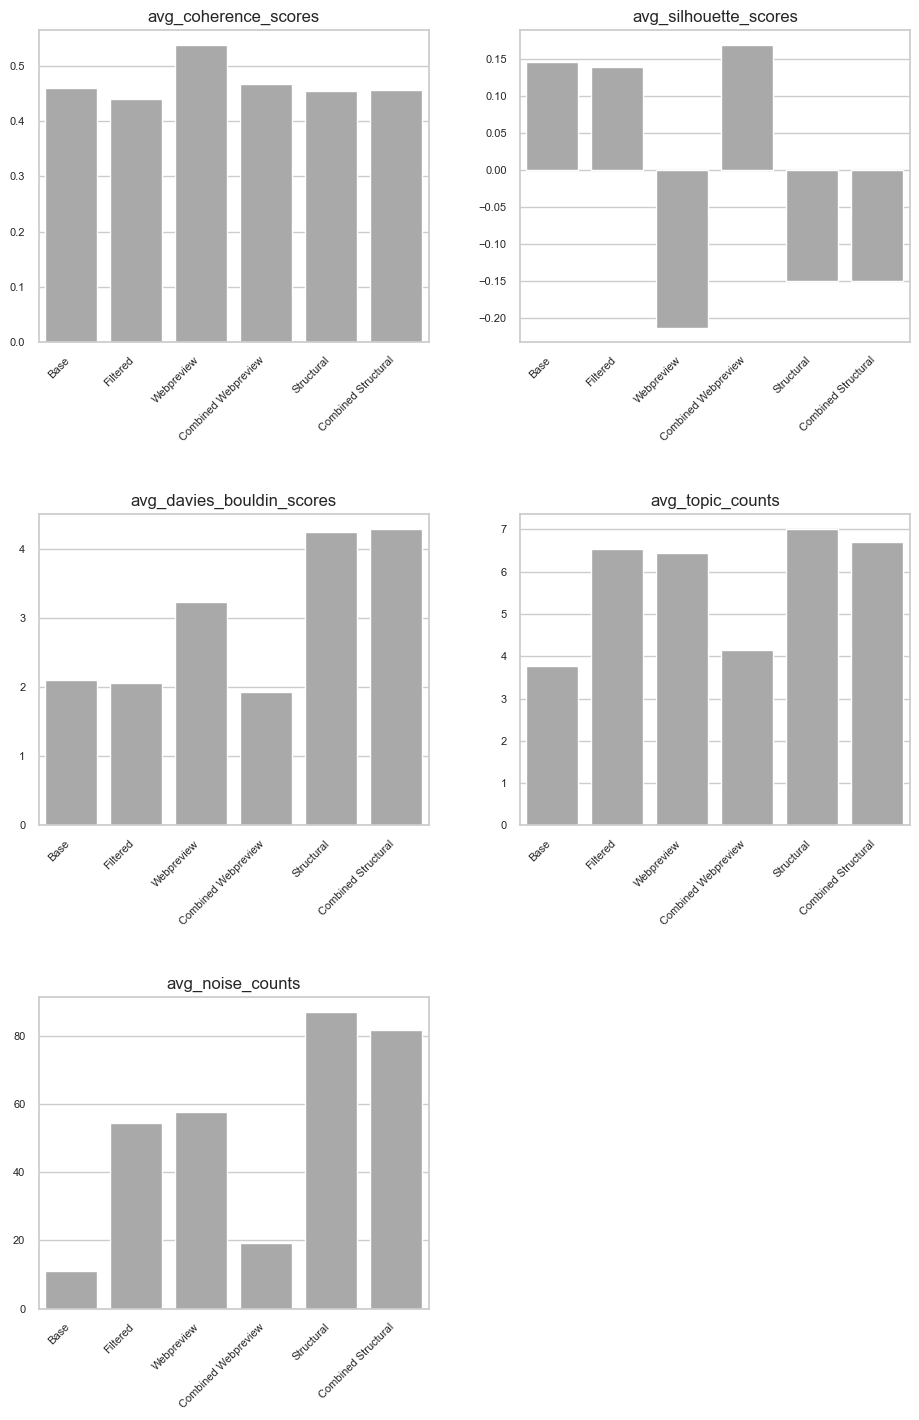

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharey=False)
axes = axes.flatten()

for i, metric in enumerate(evaluation_df.index):
    sns.barplot(data=evaluation_df.T, x=evaluation_df.columns, y=evaluation_df.loc[metric], ax=axes[i], color="darkgrey") 
    axes[i].tick_params(axis="x", rotation=45, labelsize=8)  
    axes[i].tick_params(axis="y", labelsize=8) 
    axes[i].set_ylabel("")  
    axes[i].set_xlabel("", fontsize=10, labelpad=10)  
    axes[i].set_title(metric, fontsize=12)  

    for label in axes[i].get_xticklabels():
        label.set_ha("right") 

# remove unnecessary subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.subplots_adjust(hspace=0.7)  
plt.tight_layout(pad=3.0) 

# save the barplots
dir_path = os.path.join(os.getcwd(), "../results/comparison/")
path = os.path.join(dir_path, "avg_evaluation_metrics_plots.png")
os.makedirs(os.path.dirname(dir_path), exist_ok=True)
plt.savefig(path, dpi=300)

# Show the plot
plt.show()


### Check The Similarity Of Topic Assignments Across Chats

Now, we can compare the similarities between topic assignments generated using different features. To do this, we’ll calculate the Adjusted Rand Score and visualize their pairwise similarities in a heatmap.

Before starting this analysis, however, we need to re-add a previously removed chat to the filtered dataframe. Since we consider this chat as "not clustered," we’ll assign it to the "Other" topic (-1).

The chat was presumably removed, as it consisted solely of forwarded messages from other chats in our dataset.

In [73]:
# as one chat was removed from the filtered chat vectors, the topic model has one topic less. To enable comparison, we will add it back to the vector and set it to -1
filtered_topics = filtered_topic_model.topics_
all_chat_ids = np.array(base_chat_vectors.index)
filtered_chat_ids = np.array(filtered_chat_vectors.index)
missing_chat_id = np.setdiff1d(all_chat_ids, filtered_chat_ids)[0]
missing_chat_index = np.where(all_chat_ids == missing_chat_id)[0][0]
filtered_topics_fixed = np.insert(filtered_topics, missing_chat_index, -1) # insert at the right index to maintain the order of chat assignments for comparison

print(f"Number of chat vectors: {len(all_chat_ids)}")
print(f"Number of filtered chat vectors after adding the chat: {len(filtered_topics_fixed)}")

Number of chat vectors: 351
Number of filtered chat vectors after adding the chat: 351


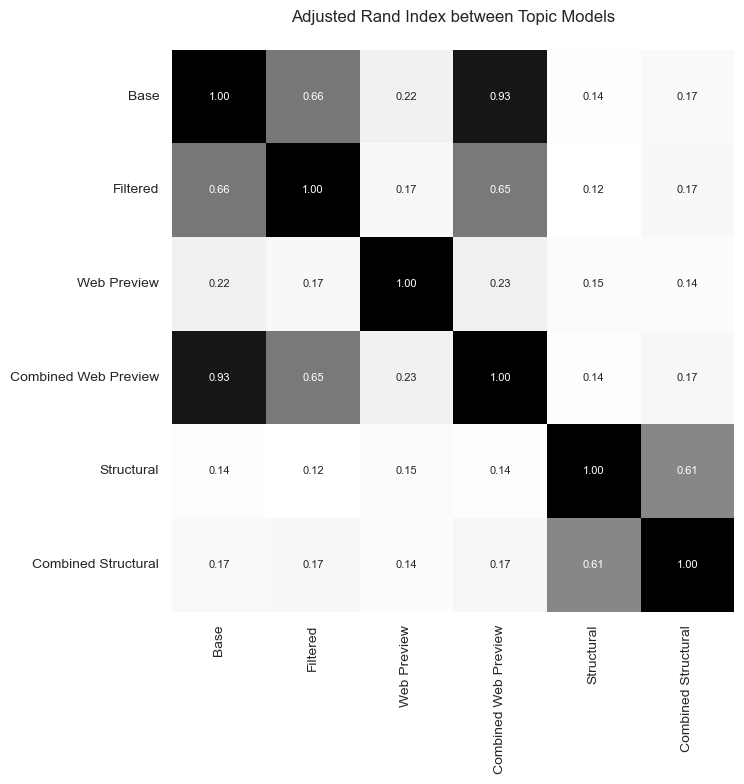

In [74]:
# load the remaining topics
base_topics = base_topic_model.topics_
webpreview_topics = webpreview_topic_model.topics_
combined_webpreview_topics = combined_webpreview_topic_model.topics_
structural_topics = structural_topic_model.topics_
combined_structural_topics = combined_structural_topic_model.topics_

# List of topic assignments
topics = [
    base_topics, 
    filtered_topics_fixed, 
    webpreview_topics, 
    combined_webpreview_topics, 
    structural_topics, 
    combined_structural_topics
]

# Labels for the heatmap
labels = ["Base", "Filtered", "Web Preview", "Combined Web Preview", "Structural", "Combined Structural"]

# Calculate the Adjusted Rand Index (ARI) matrix for all model combinations
num_models = len(topics)
rand_matrix = np.zeros((num_models, num_models))
for i in range(num_models):
    for j in range(num_models):
        rand_matrix[i, j] = adjusted_rand_score(topics[i], topics[j])

# Visualize the ARI results in a heatmap without the color bar
plt.figure(figsize=(8, 8))
ax = sns.heatmap(rand_matrix, annot=True, cmap="Greys", xticklabels=labels, yticklabels=labels, fmt=".2f", 
                 cbar=False, annot_kws={"size": 8})

# Set aspect ratio to equal and adjust font size for tick labels and title
ax.set_aspect("equal")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Adjusted Rand Index between Topic Models", fontsize=12, pad=20)

# save the heatmap
dir_path = os.path.join(os.getcwd(), "../results/comparison/")
path = os.path.join(dir_path, "topic_model_comparison_heatmap.png")
os.makedirs(os.path.dirname(dir_path), exist_ok=True)
plt.tight_layout()
plt.savefig(path, dpi=300)

# Show the heatmap
plt.show()


### Visualize The Movement Of Assignments Between Features

Finally, we map the way that topic assignments have changed for each feature when compared to the traditional approach of using aggregated message embeddings as chat representations for clustering. For this purpose, we’ll create a Sankey diagram for each feature.

In [75]:
fig = plot_topic_changes("Base", "Filtered", base_topics, filtered_topics_fixed)
path = os.path.join(os.getcwd(), "../results/filtered_embeddings/base_filtered_topic_changes.png")
fig.write_image(path, width=1600, height=600, scale=2)
fig.show()

In [76]:
fig = plot_topic_changes("Base", "Web Preview", base_topics, webpreview_topics)
path = os.path.join(os.getcwd(), "../results/webpreview_embeddings/base_web_preview_topic_changes.png")
fig.write_image(path, width=1600, height=600, scale=2)
fig.show()

In [77]:
fig = plot_topic_changes("Base", " Combined Web Preview", base_topics, combined_webpreview_topics)
path = os.path.join(os.getcwd(), "../results/combined_webpreview_embeddings/base_combined_web_preview_topic_changes.png")
fig.write_image(path, width=1600, height=600, scale=2)
fig.show()

In [78]:
fig = plot_topic_changes("Base", " Structural", base_topics, structural_topics)
path = os.path.join(os.getcwd(), "../results/structural_embeddings/base_structural_topic_changes.png")
fig.write_image(path, width=1600, height=600, scale=2)
fig.show()

In [79]:
fig = plot_topic_changes("Base", " Combined Structural", base_topics, combined_structural_topics)
path = os.path.join(os.getcwd(), "../results/combined_structural_embeddings/base_combined_structural_topic_changes.png")
fig.write_image(path, width=1600, height=600, scale=2)
fig.show()

## 9.Exports

We will now export data and visualisations used for the paper associated with these notebooks. 

#### Export Representative Messages For Presentation

In [80]:
representative_messages_paths = {
    "base": "../results/base_embeddings/representative_messages.json",
    "filtered": "../results/filtered_embeddings/representative_messages.json",
    "webpreview": "../results/webpreview_embeddings/representative_messages.json",
    "combined_webpreview": "../results/combined_webpreview_embeddings/representative_messages.json",
    "structural": "../results/structural_embeddings/representative_messages.json",
    "combined_structural": "../results/combined_structural_embeddings/representative_messages.json"
}

for feature, path in representative_messages_paths.items():
    json_path = os.path.join(os.getcwd(), path)
    csv_path = json_path.replace(".json", ".csv")  

    with open(json_path, "r") as f:
         representative_messages = json.load(f)    
         
    df = pd.DataFrame(representative_messages)
    stacked = pd.DataFrame(df.T.stack()).reset_index(level=1, drop=True)
    stacked.columns = ["Most Representative Message Texts"]
    stacked.index = stacked.index.where(stacked.index.duplicated(keep="first") == False, "")
    stacked.to_csv(csv_path, index=True)


#### Export Keywords For Presentation

In [81]:
keyword_paths = [
    "../results/base_embeddings/keywords.csv",
    "../results/filtered_embeddings/keywords.csv",
    "../results/webpreview_embeddings/keywords.csv",
    "../results/combined_webpreview_embeddings/keywords.csv",
    "../results/structural_embeddings/keywords.csv",
    "../results/combined_structural_embeddings/keywords.csv"
]

keyword_paths = [
    "../results/base_embeddings/keywords.csv",
]

topic_models = [
    base_topic_model,
    filtered_topic_model,
    webpreview_topic_model,
    combined_webpreview_topic_model,
    structural_topic_model,
    combined_structural_topic_model
]

topic_models = [
    base_topic_model,
]

for model, path in zip(topic_models, keyword_paths):
    topic_keywords = model.get_topics()
    stacked = (pd.DataFrame(topic_keywords).T
            .stack()
            .drop(index=-1)
            .apply(lambda x: x[0])
            .reset_index(level=1, drop=True))

    stacked.to_csv(os.path.join(os.getcwd(), path), index=True)